# Weekly project
This weeks weekly project is a continuation of last weeks exercises.

You are to make a handwritten number classifier. Where we will be using the [mnist dataset](https://en.wikipedia.org/wiki/MNIST_database).

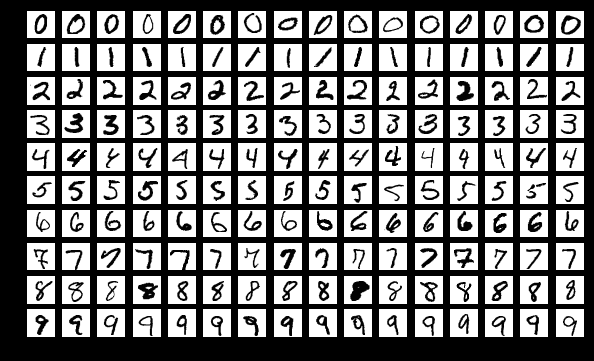

**Create a program that given an image from the mnist dataset.**
- You are free to use any algorithm you want to achieve this.
- It should be able to given a number classify what number it is.
- Accuracy should at least be 80%

If you decide to use a svm make sure you also use dimensionality reduction. SVM of the full mnist dataset will take around 4-8 hours depending on your pc.



**Challange:**
- Try to reach 98% accuracy.
- Try to classify faces with the labeled wild faces dataset [lwf](http://vis-www.cs.umass.edu/lfw/)
```{Python}
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
```

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime as dt
from sklearn.decomposition import PCA
from sklearn import datasets, svm, metrics
from sklearn.datasets import fetch_openml

def show_some_digits(images, targets, sample_size=24, title_text='Digit {}' ):
    '''
    Visualize random digits in a grid plot
    images - array of flatten gidigs [:,784]
    targets - final labels
    '''
    #随便展示12张图片
    nsamples=sample_size
    rand_idx = np.random.choice(images.shape[0], nsamples)
    images_and_labels = list(zip(images[rand_idx], targets[rand_idx]))


    img = plt.figure(1, figsize=(15, 12), dpi=160)
    for index, (image, label) in enumerate(images_and_labels):
        plt.subplot(np.ceil(nsamples/6.0), 6, index + 1)
        plt.axis('off')
        #each image is flat, we have to reshape to 2D array 28x28-784
        plt.imshow(image.reshape(28,28), cmap=plt.cm.gray_r, interpolation='nearest')
        plt.title(title_text.format(label))
    plt.show()
    
mnist = fetch_openml('mnist_784', version=1)

images = mnist.data # (70000,784), 784=28*28
targets = mnist.target # (70000,)
# 一共有70000张图片，每张图片是28*28的

# draw 12 images along with their labels
#show_some_digits(images, targets, 12)

In [90]:
# split data sets
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(images, targets, test_size=0.2)

In [91]:
import torch
import torchvision
import torchvision.transforms as transforms

# read dataset
transform = transforms.Compose((transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))))
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets, imsize, transform=None):
        super(MyDataset).__init__()
        self.images = images
        self.targets = targets
        self.imsize = imsize
        self.transform = transform
    
    def __getitem__(self, index):
        im = self.images[index, :] # ndarray
        im = im.reshape(self.imsize,self.imsize)
        # change to tensor
        #im = torch.from_numpy(im)
        im = self.transform(im)
        label = eval(self.targets[index])
        return im, label


    def __len__(self):
        return self.images.shape[0]
        

trainset = MyDataset(xtrain, ytrain, 28, transform)
trainLoader = torch.utils.data.DataLoader(dataset=trainset, batch_size=24, shuffle=False)
testset = MyDataset(xtest, ytest, 28, transform)
testLoader = torch.utils.data.DataLoader(dataset=testset, batch_size=24, shuffle=False)

In [92]:
# Build Neural Network
# Simple LeNet-5 Network since it was designed for minist
import torch.nn.functional as F
import torch.optim as op
from torch import nn
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 4 * 4, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
net = net.double()

In [96]:
# Train the model
# use gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = op.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(10):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Training Done')

cuda:0
[1,  1000] loss: 0.016
[1,  2000] loss: 0.017
[2,  1000] loss: 0.015
[2,  2000] loss: 0.017
[3,  1000] loss: 0.013
[3,  2000] loss: 0.013
[4,  1000] loss: 0.011
[4,  2000] loss: 0.011
[5,  1000] loss: 0.011
[5,  2000] loss: 0.011
[6,  1000] loss: 0.012
[6,  2000] loss: 0.011
[7,  1000] loss: 0.010
[7,  2000] loss: 0.008
[8,  1000] loss: 0.008
[8,  2000] loss: 0.009
[9,  1000] loss: 0.008
[9,  2000] loss: 0.008
[10,  1000] loss: 0.008
[10,  2000] loss: 0.010
Finished Training


In [97]:
# Test
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))


Accuracy: 98 %


In [98]:
# New dataset
from sklearn.datasets import fetch_lfw_people
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

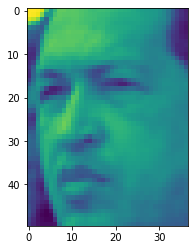

In [104]:
images = lfw_people.data # (1288,1850), 1850=50*37
targets = lfw_people.target # (1288,)
im = images[0,:]
im = im.reshape(50, 37)
plt.figure()
plt.imshow(im)

In [106]:
# split data sets
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(images, targets, test_size=0.2)

In [150]:

transform = transforms.Compose((transforms.ToTensor(), transforms.Normalize(mean=(0.5,), std=(0.5,))))
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, images, targets, transform=None):
        super(MyDataset).__init__()
        self.images = images
        self.targets = targets
        self.transform = transform
    
    def __getitem__(self, index):
        im = self.images[index, :] # ndarray
        im = im.reshape(50,37)
        # change to tensor
        #im = torch.from_numpy(im)
        im = self.transform(im)
        im = im.double()
        label = self.targets[index]
        return im, label


    def __len__(self):
        return self.images.shape[0]
        

trainset = MyDataset(xtrain, ytrain, transform)
trainLoader = torch.utils.data.DataLoader(dataset=trainset, batch_size=12, shuffle=False)
testset = MyDataset(xtest, ytest, transform)
testLoader = torch.utils.data.DataLoader(dataset=testset, batch_size=12, shuffle=False)

In [151]:
# Build Neural Network
# Simple LeNet-5 Network since it was designed for minist
import torch.nn.functional as F
import torch.optim as op
from torch import nn
class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.fc1 = nn.Linear(16 * 11 * 7, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 11 * 7)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
net = Net()
net = net.double()

In [154]:
# Train the model
# use gpu if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
net.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = op.SGD(net.parameters(), lr=0.001, momentum=0.9)
for epoch in range(100):  # loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
print('Training Done')

cuda:0
Training Done


In [155]:
# Test
correct = 0
total = 0
with torch.no_grad():
    for data in testLoader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print('Accuracy: %d %%' % (100 * correct / total))

Accuracy: 82 %
